In [1]:
import pandas as pd

resolution = ''
#Change dimension in two places
prefix_path = ''
ground_truth_prefix = ''
images_prefix = ''
segmented_images=''
color = ''
test_segmented_images=''

In [2]:
# Dynamically construct the path to the Excel file based on the color variable
excel_file_path_training = prefix_path+'TrainingData.xlsx'
excel_file_path_testing = prefix_path+'TestingData.xlsx'


# Read the Excel file into a DataFrame
grapes_df = pd.read_excel(excel_file_path_training)
testing_grapes_df = pd.read_excel(excel_file_path_testing)

In [3]:
# Update the 'Image' column to reflect the correct resolution, and prepend the prefix path

grapes_df['Image'] = prefix_path + segmented_images + grapes_df['Image'].str.replace('Resolution', resolution)


testing_grapes_df['Image'] = prefix_path + test_segmented_images + testing_grapes_df['Image'].str.replace('Resolution', resolution)


# Display the DataFrame
print(grapes_df.head())
print(testing_grapes_df.head())




                                               Image  \
0  /content/drive/MyDrive/Dataset/GrapeSet/Segmen...   
1  /content/drive/MyDrive/Dataset/GrapeSet/Segmen...   
2  /content/drive/MyDrive/Dataset/GrapeSet/Segmen...   
3  /content/drive/MyDrive/Dataset/GrapeSet/Segmen...   
4  /content/drive/MyDrive/Dataset/GrapeSet/Segmen...   

                            Mask  Weight  Count  
0  Green/Setup1/A-B-C_SV180.jpeg    1131     75  
1  Green/Setup1/A-D-G_SV180.jpeg    1400    113  
2  Green/Setup1/A-F-J_SV180.jpeg    1369    108  
3  Green/Setup1/B-I-G_SV180.jpeg    1222     95  
4  Green/Setup1/D-B-H_SV180.jpeg    1418    126  
                                               Image  \
0  /content/drive/MyDrive/Dataset/GrapeSet/TestSe...   
1  /content/drive/MyDrive/Dataset/GrapeSet/TestSe...   
2  /content/drive/MyDrive/Dataset/GrapeSet/TestSe...   
3  /content/drive/MyDrive/Dataset/GrapeSet/TestSe...   
4  /content/drive/MyDrive/Dataset/GrapeSet/TestSe...   

                          

In [4]:
#testing_grapes_df = testing_grapes_df[testing_grapes_df['Image'].str.contains(color)]

In [5]:
print(len(grapes_df))

440


In [6]:
print(len(testing_grapes_df))

120


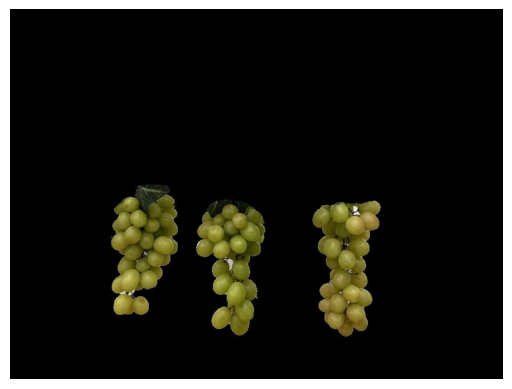

In [7]:
from PIL import Image
import matplotlib.pyplot as plt


image_path = grapes_df['Image'].iloc[17]  # Get the first image path

# Read the image
image = Image.open(image_path)


#Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [8]:
import cv2
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def load_and_preprocess_image(image_path, target_size=(480, 640)):
    # Load image
    img = cv2.imread(image_path)
    # Resize image
    img_resized = cv2.resize(img, (target_size[1], target_size[0]))  # Correct order: height, width
    # Normalize the image
    img_normalized = img_resized / 255.0
    return img_normalized

# Assuming grapes_df is for training and testing_grapes_df is for testing
# and both have the 'Image', 'Count', and 'Weight ' columns
# Prepare training data
X_train = np.array([load_and_preprocess_image(path) for path in grapes_df['Image']])
y_counts_train = grapes_df['Count'].values
y_weights_train = grapes_df['Weight'].values


In [9]:


# Prepare testing data
X_test = np.array([load_and_preprocess_image(path) for path in testing_grapes_df['Image']])
y_counts_test = testing_grapes_df['Count'].values
y_weights_test = testing_grapes_df['Weight'].values


In [ ]:

# Model input layer adjusted to the target size used in the preprocessing
input_layer = Input(shape=(480, 640, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Shared dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Separate output layers for count and weight
count_output = Dense(1, activation='linear', name='count_output')(x)
weight_output = Dense(1, activation='linear', name='weight_output')(x)

# Define the model with the input layer and two output layers
model = Model(inputs=input_layer, outputs=[count_output, weight_output])

# Compile the model with multiple outputs
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'count_output': 'mean_squared_error', 'weight_output': 'mean_squared_error'},
              metrics={'count_output': ['mae'], 'weight_output': ['mae']})

# Train the model with the training data
model.fit(X_train, {'count_output': y_counts_train, 'weight_output': y_weights_train}, epochs=50, batch_size=8)




Epoch 1/50
55/55 [==============================] - 14s 95ms/step - loss: 629800.9375 - count_output_loss: 53403.5742 - weight_output_loss: 576397.1875 - count_output_mae: 183.5538 - weight_output_mae: 595.6354
Epoch 2/50
55/55 [==============================] - 5s 98ms/step - loss: 132473.3125 - count_output_loss: 34189.2500 - weight_output_loss: 98284.0703 - count_output_mae: 147.2056 - weight_output_mae: 247.9767
Epoch 3/50
55/55 [==============================] - 5s 96ms/step - loss: 104272.6641 - count_output_loss: 22759.2363 - weight_output_loss: 81513.3984 - count_output_mae: 117.8670 - weight_output_mae: 230.2223
Epoch 4/50
55/55 [==============================] - 5s 98ms/step - loss: 92815.5078 - count_output_loss: 18875.8730 - weight_output_loss: 73939.6484 - count_output_mae: 110.0406 - weight_output_mae: 221.2451
Epoch 5/50
55/55 [==============================] - 5s 97ms/step - loss: 98311.3984 - count_output_loss: 14230.2090 - weight_output_loss: 84081.1875 - count_output

In [ ]:
# Evaluate the model with the testing data
model_evaluation = model.evaluate(X_test, {'count_output': y_counts_test, 'weight_output': y_weights_test})


In [ ]:
import numpy as np

# Generate predictions for the test dataset
predictions = model.predict(X_test)

# Assuming the first output of your model is the count prediction
predicted_counts = predictions[0].flatten()  # Flatten in case predictions are in a 2D array

# Assuming `y_counts_test` is your actual count values
actual_counts = y_counts_test.flatten()  # Flatten to ensure it matches predicted_counts shape

mae_count = model_evaluation[3]

# Calculate the accuracy for each prediction
accuracies = (1 - np.abs(predicted_counts - actual_counts) / actual_counts) * 100

# Optionally, calculate the mean accuracy to get a single metric representing overall performance
mean_accuracy = np.mean(accuracies)

# Round the mean squared error and mean accuracy to two decimal places
mae_rounded = np.round(mae_count, 0)
mean_accuracy_rounded = np.round(mean_accuracy, 2)

print("MAE:", mae_rounded)
print("Mean Accuracy (%):", mean_accuracy_rounded)
